In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae, mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import norm, probplot
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p

from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import winsound
import time

In [3]:
duration = 5000  # milliseconds
freq = 440  # Hz

#### Função para calcular o score do no modelo

In [4]:
def rmse(y_true, preds):
    return mse(y_true, preds, squared=False)
    
def score_(X_train, X_valid, y_train, y_valid, model = LinearRegression(n_jobs=5)):
    '''
    Score model with root mean squared error (RMSE)
    '''
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return rmse(y_valid, preds)
#     return mae(y_valid, preds)

In [5]:
# carregando o dataset, a extração é do dataset disponível em: https://www.kaggle.com/datasets/argonalyst/sao-paulo-real-estate-sale-rent-april-2019?resource=download
# Lembrando que também conseguimos utilizar o algoritmo de extração direto de sistemas de alguel.

In [6]:
df = pd.read_csv('data/sao-paulo-properties-april-2019.csv')
df.head(3)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665


In [7]:
df[['District', 'City']] = df.District.str.split('/', expand=True)
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,City
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.543138,-46.479486,São Paulo
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.550239,-46.480718,São Paulo
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.542818,-46.485665,São Paulo
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.547171,-46.483014,São Paulo
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,rent,apartment,-23.525025,-46.482436,São Paulo


Price - Valor do imóvel em Reais (BRL)

Condo - Custo do condomínio em Reais (BRL)

Size - Area do imóvel em metros quadrados M²

Rooms - Número de quartos

Toilets - Total de banheiros

Suites - Total de quartos com banheiros

Parking - Número de vagas de estacionamento

Elevator - Valor binário se existe elevador

Furnished- Se o imóvel é ou não mobiliado

Swimming Pool - Existe ou não piscina

New = Imóvel é novo

District - Bairro e cidade onde o imóvel está localizado

Negotiation Type - Tipo de necociação (aluguel, venda...)

Property Type - Tipo de imóvel (apartamento, casa)

Latitude - posição geográfica

Longitude - posição geográfica

City - Cidade

## Vamos filtrar os campos, pois queremos apenas valores de aluguel, para apartamentos

In [8]:
df['Negotiation Type'].value_counts()

rent    7228
sale    6412
Name: Negotiation Type, dtype: int64

In [9]:
df = df[df['Negotiation Type'] == 'rent']

In [10]:
df['Property Type'].value_counts()

apartment    7228
Name: Property Type, dtype: int64

## Quais são os dados nulos?

In [11]:
df.isna().sum().sort_values()

Price               0
Latitude            0
Property Type       0
Negotiation Type    0
District            0
New                 0
Swimming Pool       0
Longitude           0
Furnished           0
Parking             0
Suites              0
Toilets             0
Rooms               0
Size                0
Condo               0
Elevator            0
City                0
dtype: int64

# Quantos bairros tempos?

In [12]:
df['District'].nunique()

94

# Quais os bairros com mais mais disponibilidade?

In [13]:
df['District'].value_counts().sort_values(ascending=False).to_frame().head(10)

,District
Mooca,178
Moema,163
Vila Mariana,161
Morumbi,159
Pinheiros,153
Cambuci,153
Butantã,152
Vila Leopoldina,148
Itaim Bibi,144
Jardim Paulista,141


### Qual a médica de cada bairro?

In [14]:
df.groupby(['District'], as_index=False).Price.median().sort_values(by='Price', ascending=False)

,District,Price
31,Iguatemi,7200.0
33,Itaim Bibi,6500.0
40,Jardim Paulista,6000.0
90,Vila Olimpia,5500.0
0,Alto de Pinheiros,5000.0
...,...,...
45,Lajeado,925.0
39,Jardim Helena,910.0
44,José Bonifácio,900.0
34,Itaim Paulista,825.0


Vamos pegar uma amostra de valores aleatórios no dataframe.

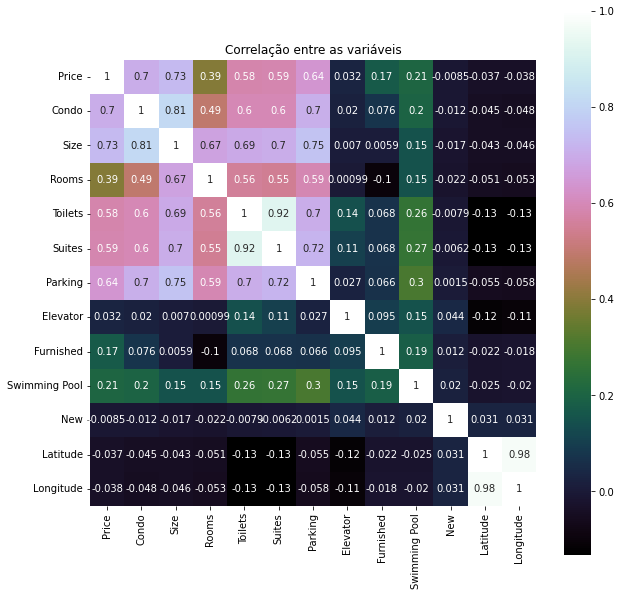

In [15]:
correlation = df.corr()
plt.figure(figsize=(10,10))
plt.title('Correlação entre as variáveis')
sns.heatmap(correlation, square=True,annot=True,cmap='cubehelix')
plt.show()

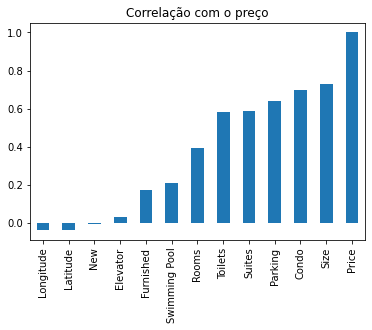

In [16]:
plt.title('Correlação com o preço')
correlation.Price.sort_values().plot.bar()
plt.show()

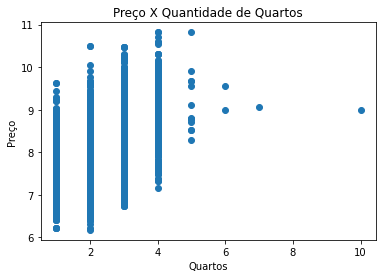

In [17]:
fig, ax= plt.subplots()
ax.scatter(x=df['Rooms'], y=np.log(df['Price']))
plt.ylabel('Preço')
plt.xlabel('Quartos')
plt.title("Preço X Quantidade de Quartos")
plt.show()

In [18]:
df = df[(df.Price <= 20000) & (df.Rooms <= 5)]

In [19]:
test_sample = df.sample(20)
df = df.drop(test_sample.index).reset_index(drop=True)

c:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


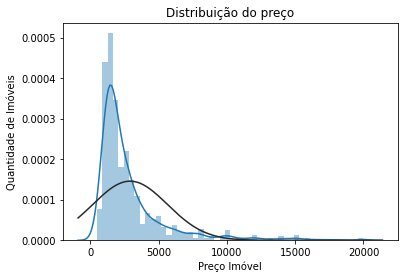

In [20]:
sns.distplot(df.Price, fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Distribuição do preço')
plt.show()

Vamos ajustar o preço para uma distribuição `normal`

c:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


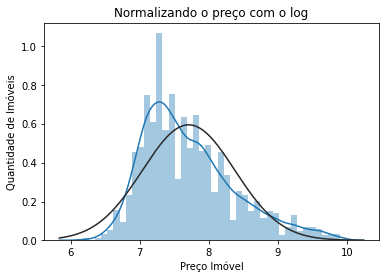

In [21]:
sns.distplot(np.log(df.Price), fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Normalizando o preço com o log')
plt.show()

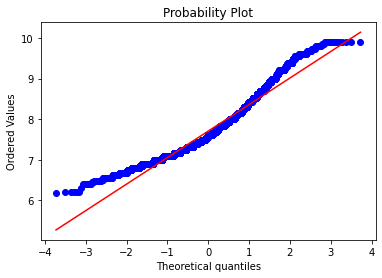

In [22]:
probplot(np.log(df.Price), plot=plt)
plt.show()

In [23]:
df.Price = np.log(df.Price)

In [24]:
droped_columns = ['Price', "Condo",'Negotiation Type', 'Property Type', 'Latitude', 'Longitude', 'City', 'New']
X = df.drop(columns=droped_columns)
y = df['Price']

In [25]:
# Vamos aplicar o OrdinarEnconder para a coluna categoria, que no caso é apenas o bairro
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

ordinal_encoder.fit(X[['District']].values)
X[['District']] =  ordinal_encoder.transform(X[['District']].values)

### PCA

In [26]:
ss = StandardScaler()
ss.fit(X)
X_standard = ss.transform(X)

pca = PCA(n_components=6)
pca.fit(X_standard)
print(f"PCA - Explained CumSum: {np.round(pca.explained_variance_ratio_.cumsum(), decimals=2)}")

PCA - Explained CumSum: [0.43 0.57 0.68 0.78 0.87 0.93]


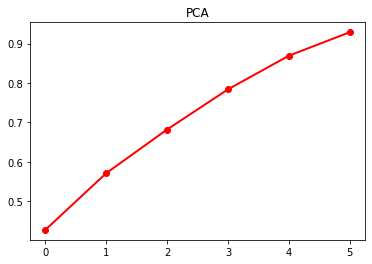

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
plt.title('PCA')
plt.show()

In [28]:
# Vamos criar nossa base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print("RMSE com OrdinalEnconder:") 
print(score_(X_train, X_test, y_train, y_test))

RMSE com OrdinalEnconder:
0.41507034153195954


In [129]:
#Cuidado essa tarefa leva cerca de 50 minutos
start=time.time()
clf = GridSearchCV(RandomForestRegressor(), {'n_estimators': [100, 250, 700],
#                                        'criterion': ["squared_error", "absolute_error", "poisson"],
                                       'max_depth': [3, 13, 50],
                                       'min_samples_split': [2, 5, 10],
                                       'min_samples_leaf': [2, 6, 10, 15],
                                       'n_jobs': [2, 5, 15],
                                         'verbose': [3]
                                            },
                  scoring='neg_root_mean_squared_error',
                  cv=5,
                  error_score='raise')
# clf.fit(label_X_train, y_train)
clf.fit(df_pca, y_train)
winsound.Beep(freq, duration)
print(np.round(time.time()-start, 2))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[P

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 228 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    4.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed: 

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    4.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent w

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks     

[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Paral

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=15)]: Using ba

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 209 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 221 out of 250 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=15)]: Done 123 tasks      | elapsed:    4.0s
[Parallel(n_jobs=15)]: Done 588 tasks      | elapsed:    4.4s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    4.6s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.5s fi

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent worker

[Parallel(n_jobs=15)]: Done 203 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    4.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s

[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.5s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.8s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elaps

[Parallel(n_jobs=2)]: Done 206 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 206 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 206 tasks      | 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 380 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 380 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[P

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    4.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBack

[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    5.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Paral

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=15)]: Done 128 tasks    

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent w

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: 

[Parallel(n_jobs=15)]: Done 215 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend Loky

[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.7s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent wo

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Pa

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    4.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 380 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.7s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend w

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 206 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 206 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBack

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 380 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 380 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent wo

[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    3.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | 

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent w

[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=15)]: Done 121 tasks      | elapsed:    4.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    4.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 209 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tas

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=15)]: Done 126 tasks      | elapsed:    4.1s
[Parallel(n_jobs=15)]: Done 588 tasks      | elapsed:    4.5s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    4.6s finished
[Para

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent worker

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 215 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    8.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      |

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.3s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.5s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend w

[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    4.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 250 out of 250 | 

[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    5.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    5.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Paral

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks     

[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    5.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 599 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    6.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parall

[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | 

[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Paral

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend

[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=15)]: Done 123 tasks      | elapsed:    4.1s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    4.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 

[Parallel(n_jobs=5)]: Done 683 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Paral

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n

[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elaps

[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.3s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elaps

[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    4.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    4.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    4.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks     

[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    5.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    6.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | 

[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.0s finished
[P

[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    4.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    4.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 215 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend Loky

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    4.0s
[Parallel(n_jobs=15)]: Done 588 tasks      | elapsed:    4.6s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    4.7s finished
[Para

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent worker

[Parallel(n_jobs=15)]: Done 215 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyB

[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 258 tasks      | elaps

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    4.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using ba

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    4.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks     

[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    6.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 529 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    6.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | 

[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 683 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 683 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.8s finished
[P

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend

[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    4.1s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    4.4s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 215 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend Loky

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 683 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    4.1s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    5.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concu

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent worker

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 215 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 215 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tas

[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.3s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elaps

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    4.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using ba

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    5.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    5.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks     

[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    5.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 564 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    6.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | 

[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.0s finished
[P

[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    3.9s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    4.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend Loky

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=15)]: Done 121 tasks      | elapsed:    4.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    4.7s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concu

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent worker

[Parallel(n_jobs=15)]: Done 218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    7.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s

[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    1.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elaps

[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 222 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 222 tasks      | 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[P

[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 228 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    4.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 con

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    6.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent w

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks     

[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    2.0s finished
[P

building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700
building tree 41 of 700
building tree 42 of 700
b

[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.4s


building tree 144 of 700
building tree 145 of 700
building tree 146 of 700
building tree 147 of 700
building tree 148 of 700
building tree 149 of 700
building tree 150 of 700
building tree 151 of 700
building tree 152 of 700
building tree 153 of 700
building tree 154 of 700
building tree 155 of 700
building tree 156 of 700
building tree 157 of 700
building tree 158 of 700
building tree 159 of 700
building tree 160 of 700
building tree 161 of 700
building tree 162 of 700
building tree 163 of 700
building tree 164 of 700
building tree 165 of 700
building tree 166 of 700
building tree 167 of 700
building tree 168 of 700
building tree 169 of 700
building tree 170 of 700
building tree 171 of 700
building tree 172 of 700
building tree 173 of 700
building tree 174 of 700
building tree 175 of 700
building tree 176 of 700
building tree 177 of 700
building tree 178 of 700
building tree 179 of 700
building tree 180 of 700
building tree 181 of 700
building tree 182 of 700
building tree 183 of 700


[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    1.0s


building tree 274 of 700
building tree 275 of 700
building tree 276 of 700
building tree 277 of 700
building tree 278 of 700
building tree 279 of 700
building tree 280 of 700
building tree 281 of 700
building tree 282 of 700
building tree 283 of 700
building tree 284 of 700
building tree 285 of 700
building tree 286 of 700
building tree 287 of 700
building tree 288 of 700
building tree 289 of 700
building tree 290 of 700
building tree 291 of 700
building tree 292 of 700
building tree 293 of 700
building tree 294 of 700
building tree 295 of 700
building tree 296 of 700
building tree 297 of 700
building tree 298 of 700
building tree 299 of 700
building tree 300 of 700
building tree 301 of 700
building tree 302 of 700
building tree 303 of 700
building tree 304 of 700
building tree 305 of 700
building tree 306 of 700
building tree 307 of 700
building tree 308 of 700
building tree 309 of 700
building tree 310 of 700
building tree 311 of 700
building tree 312 of 700
building tree 313 of 700


[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    1.7s


building tree 531 of 700
building tree 532 of 700
building tree 533 of 700
building tree 534 of 700
building tree 535 of 700
building tree 536 of 700
building tree 537 of 700
building tree 538 of 700
building tree 539 of 700
building tree 540 of 700
building tree 541 of 700
building tree 542 of 700
building tree 543 of 700
building tree 544 of 700
building tree 545 of 700
building tree 546 of 700
building tree 547 of 700
building tree 548 of 700
building tree 549 of 700
building tree 550 of 700
building tree 551 of 700
building tree 552 of 700
building tree 553 of 700
building tree 554 of 700
building tree 555 of 700
building tree 556 of 700
building tree 557 of 700
building tree 558 of 700
building tree 559 of 700
building tree 560 of 700
building tree 561 of 700
building tree 562 of 700
building tree 563 of 700
building tree 564 of 700
building tree 565 of 700
building tree 566 of 700
building tree 567 of 700
building tree 568 of 700
building tree 569 of 700
building tree 570 of 700


[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    2.4s finished


3497.36


In [31]:
clf.best_estimator_

RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700,
                      n_jobs=5, verbose=3)

In [130]:
clf.best_estimator_

RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700,
                      n_jobs=15, verbose=3)

### Quais os melhores hiperparametros?

`RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700, n_jobs=15)`

In [30]:
score_(X_train, X_test, y_train, y_test, XGBRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700, n_jobs=15, verbose=0))

[00:20:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




0.3168136784530621

In [32]:
pipe = Pipeline(steps=[
    ("normalizacao", StandardScaler()),
    ('PCA', PCA(n_components=8)),
    ('model', XGBRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700, n_jobs=15, verbose=0))
])
scores = cross_val_score(pipe, X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error',
                          error_score='raise')
print(-1 * scores)

[00:21:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:21:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:22:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples

In [ ]:
[0.27441885 0.2772386  0.26779509 0.28211714 0.27237849]


In [33]:
pipe.fit(X_test.values, y_test)

[00:22:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_leaf", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('normalizacao', StandardScaler()),
                ('PCA', PCA(n_components=8)),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=50, max_leaves=0, min_child_weight=1,
                              min_samples_leaf=2, missing=nan,
                              monotone_constraints='()', n_estimators=700,
                              n_jobs=15, num_parallel_tree=1, p

In [35]:
pipe.score(X_test.values, y_test)

0.9966890682733616

In [36]:
np.exp(score_(X_train, X_test, y_train, y_test,RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700,
                      n_jobs=5, verbose=0)))

1.3944607741118094

In [37]:
predict = pipe.predict(X_test.values)

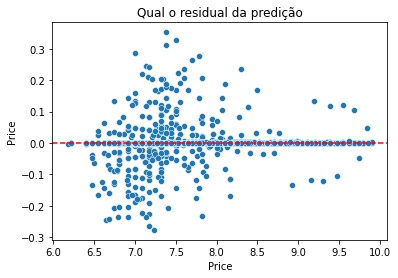

In [38]:
residual = y_test - predict
plt.title('Qual o residual da predição')
sns.scatterplot(x=y_test, y=residual)
plt.axhline(y=0, color='red', ls='--');

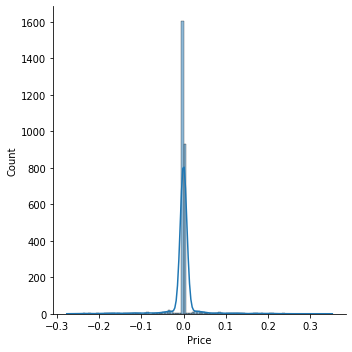

In [39]:
sns.displot(residual, bins=100, kde=True);

In [40]:
round(r2_score(y_test, predict),2)

1.0

Como temos poucas colunas, vamos manter as 5 colunas inicias

In [55]:
from joblib import dump, load

In [56]:
dump(pipe, 'models\pipe_rfr.joblib')
dump(ordinal_encoder, 'models\ordinal_encoder.joblib')
dump(pca, 'models\pca.joblib')

['models\\pca.joblib']

In [679]:
ordinal_encoder = load('models\ordinal_encoder.joblib')

In [41]:
test_district = test_sample['District']

In [42]:
test_sample[['District']] = ordinal_encoder.transform(test_sample[['District']].values)

In [43]:
test_sample.head(3)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,City
1555,2300,770,82,3,2,1,2,1,0,1,0,92.0,rent,apartment,-23.597235,-46.742009,São Paulo
809,3000,856,62,1,2,1,1,1,1,1,0,14.0,rent,apartment,-23.625116,-46.665969,São Paulo
2318,1200,490,31,1,1,0,1,0,0,0,0,10.0,rent,apartment,-23.545395,-46.616793,São Paulo


In [44]:
test_sample_true = test_sample['Price']

In [45]:
test_sample.drop(columns=droped_columns,  inplace=True)

In [52]:
', '.join(list([str(int(x)) for x in np.round(np.exp(pipe.predict(test_sample.values)))]))

'2223, 2107, 1508, 9108, 1625, 1988, 1297, 906, 4982, 2999, 5236, 1090, 949, 1389, 2024, 6472, 1626, 1286, 1601, 1900'

In [53]:
', '.join([str(x) for x in test_sample_true.values])

'2300, 3000, 1200, 6000, 1400, 700, 800, 1132, 1600, 3000, 4100, 1900, 900, 1900, 2500, 6000, 2700, 905, 1600, 1150'

In [48]:
pipe.score(test_sample.values, np.log(test_sample_true))

0.44900099252863257